In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras_tuner as kt


# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")

In [19]:
# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")
min_max_values = df.drop(columns=['acq_date', 'deforested']).agg(['min', 'max'])

for column in df.columns:
    if column not in ['acq_date', 'deforested']:
        x_min = min_max_values.loc['min', column]
        x_max = min_max_values.loc['max', column]
        df[f'std_{column}'] = (df[column] - x_min) / (x_max - x_min)

df.drop(columns=['acq_date'], inplace=True)
df.rename(columns={'DEM': 'elevation'}, inplace=True)
df.rename(columns={'std_DEM': 'std_elevation'}, inplace=True)

In [20]:
# Handle missing values
df_cleaned = df.dropna()

In [21]:
# Separate features and target variable
X = df_cleaned.drop(columns=['deforested'])  # Features
y = df_cleaned['deforested']  # Target variable

In [22]:
# Check for class imbalance
print("Class distribution:")
print(df_cleaned['deforested'].value_counts())


Class distribution:
deforested
0    3532
1    1569
Name: count, dtype: int64


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [24]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=256, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='deforestation_tuning'
)


Reloading Tuner from keras_tuner_dir/deforestation_tuning/tuner0.json


In [27]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [28]:
# Run the tuner search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


In [29]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Re-train the best model to get the training history
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100


/Users/chema./Documents/Programming/GuadaHack/MLmodel/ForestForecastML/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/chema./Documents/Programming/GuadaHack/MLmodel/ForestForecastML/venv/lib/python3.12/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/Use

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7604 - loss: 0.4359 - val_accuracy: 0.7864 - val_loss: 0.4159
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7774 - loss: 0.4275 - val_accuracy: 0.7871 - val_loss: 0.4141
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7705 - loss: 0.4349 - val_accuracy: 0.7838 - val_loss: 0.4212
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7652 - loss: 0.4344 - val_accuracy: 0.7831 - val_loss: 0.4243
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7768 - loss: 0.4140 - val_accuracy: 0.7812 - val_loss: 0.4156
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7768 - loss: 0.4182 - val_accuracy: 0.7799 - val_loss: 0.4257
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4174 - val_accuracy: 0.7851 - val_loss: 0.4210
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7704 - loss: 0.4286 - val_accuracy: 0.7825

In [30]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
confusion = confusion_matrix(y_test_classes, y_pred_classes)
classification_rep = classification_report(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.79
Confusion Matrix:
[[860 200]
 [126 345]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1060
           1       0.63      0.73      0.68       471

    accuracy                           0.79      1531
   macro avg       0.75      0.77      0.76      1531
weighted avg       0.80      0.79      0.79      1531



In [31]:
# Calculate false negatives and false positives using the confusion matrix
tn, fp, fn, tp = confusion.ravel()

print(f"Number of False Negatives (FN): {fn}")
print(f"Number of False Positives (FP): {fp}")

Number of False Negatives (FN): 126
Number of False Positives (FP): 200


In [32]:
# Identify and print false negatives and false positives
false_negatives = (y_test_classes == 1) & (y_pred_classes == 0)
false_positives = (y_test_classes == 0) & (y_pred_classes == 1)

false_negative_indices = np.where(false_negatives)[0]
false_positive_indices = np.where(false_positives)[0]

print("False Negatives (Missed Deforested Areas):")
print(df_cleaned.iloc[false_negative_indices])

print("False Positives (False Alarms of Deforestation):")
print(df_cleaned.iloc[false_positive_indices])

False Negatives (Missed Deforested Areas):
      longitude  latitude    elevation  deforested    lst  prcp  7dayprecip  \
50      80.5164   29.1591   770.510803           1  33.69   0.0   49.298845   
58      80.2161   28.8633   190.449966           0  36.49   0.0    4.485003   
80      82.6824   27.9159   640.228516           1  37.13   0.0    0.000000   
85      80.1938   29.1102   707.070862           1  35.19   0.0    0.000000   
89      81.5925   28.3732   319.956818           1  34.33   0.0    1.495679   
...         ...       ...          ...         ...    ...   ...         ...   
1865    83.1836   28.0217  1247.225098           0  15.07   0.0   19.111469   
1876    83.9858   27.5251   263.400146           0  30.19   0.0    0.000000   
1878    80.4282   29.1105   812.778687           1  33.29   0.0    6.295666   
1901    80.4491   28.7627   190.000092           0  31.91   0.0    7.203955   
1921    80.3874   29.1610   801.544373           0  35.73   0.0    0.000000   

        

In [33]:
# Descriptive explanation
print("\nFalse Negatives: Instances where the model predicted 'not deforested' but the area was actually deforested.")
print("These are critical as they represent missed detections, which could lead to unmanaged deforestation.\n")

print("False Positives: Instances where the model predicted 'deforested' but the area was actually not deforested.")
print("These are less critical than false negatives but still problematic as they could lead to unnecessary resource allocation and alarm.\n")



False Negatives: Instances where the model predicted 'not deforested' but the area was actually deforested.
These are critical as they represent missed detections, which could lead to unmanaged deforestation.

False Positives: Instances where the model predicted 'deforested' but the area was actually not deforested.
These are less critical than false negatives but still problematic as they could lead to unnecessary resource allocation and alarm.



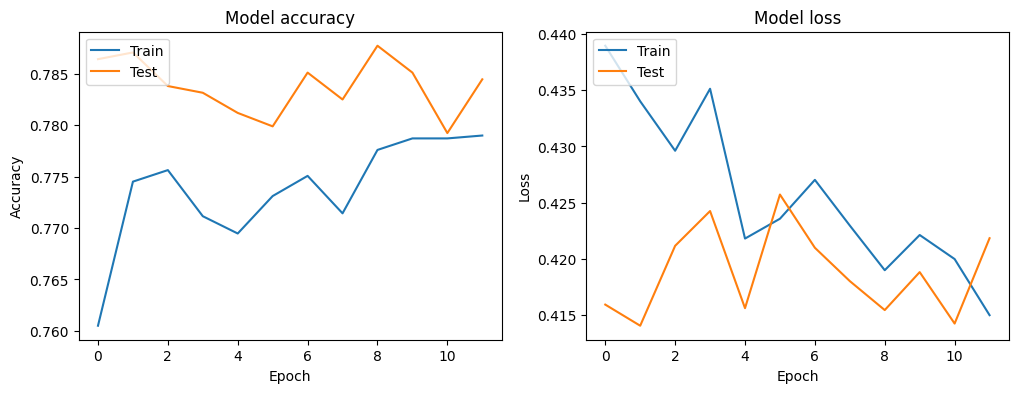

In [34]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()